In [1]:
import os
import pickle

import numpy as np
import cv2

# %matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
FOLDER = "../data/images/chess_board/"

# Calibration de la camera

Nous pensions que la distortion de la camera due au fish eye pouvait poser des problèmes car les images générées n'avaient pas cette distortion.

Les 2 grandes parties sont l'analyse de cette distortion à partir d'images d'un échiquer puis son application à la distortion.

Cf partie 4 section 7.1 du rapport

### Liste des cellules

 1. Comptabilisation du nombre d'images pouvant servir à l'analyse
 1. Récupération des points de calibration
 1. Sauvegarde des points
 1. Test de la sauvegarde
 1. Calcul de la matrice de distortion puis application

# Comptabilisation du nombre d'images pouvant servir à l'analyse

[(5, 5), (5, 4), (5, 3), (4, 5), (4, 4), (4, 3), (3, 5), (3, 4), (3, 3)]


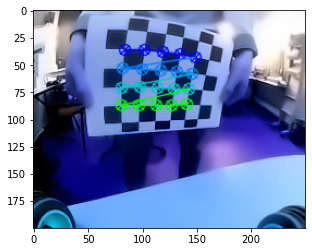

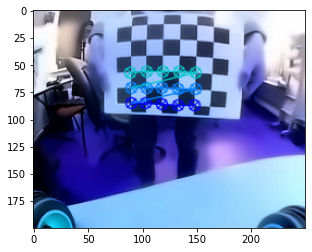

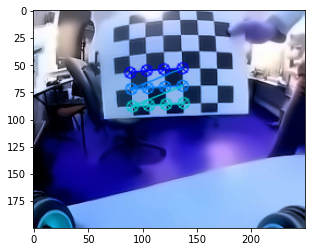

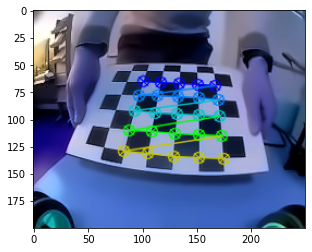

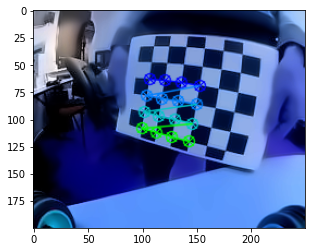

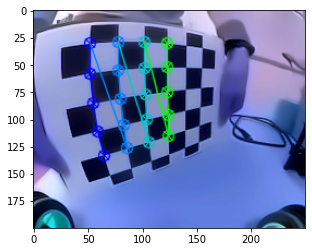

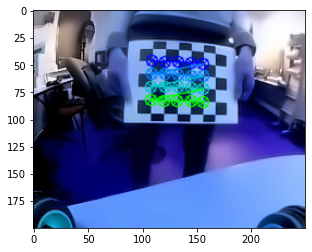

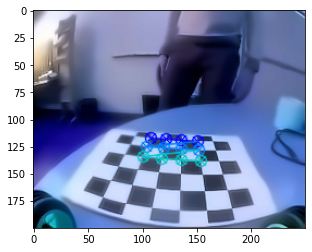

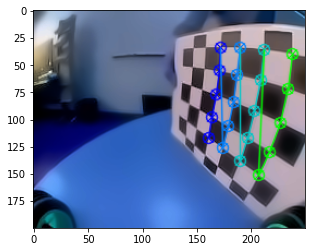

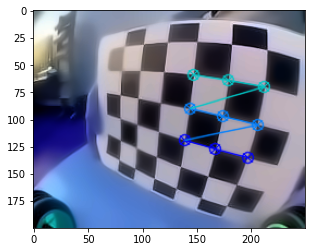

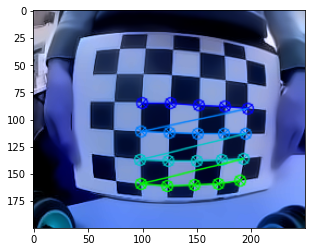

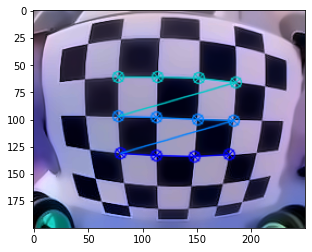

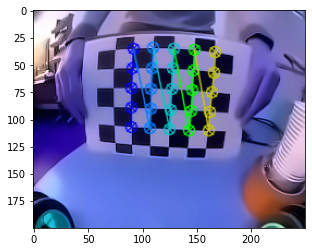

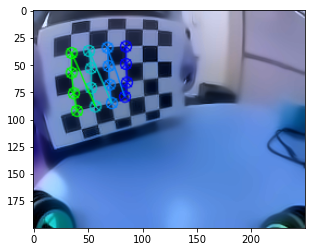

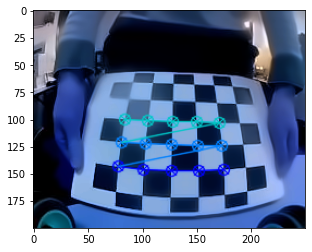

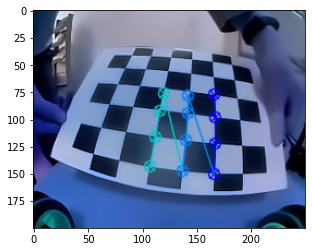

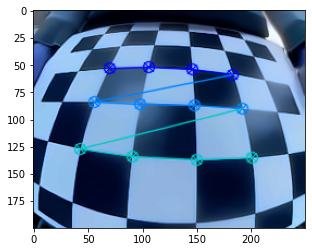

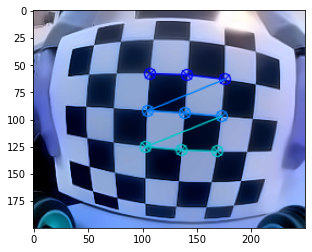

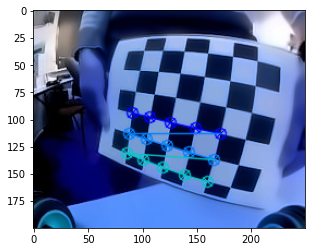

19


In [3]:
success = 0

# meshgrid
n = [(x, y) for x in range(3, 6) for y in range(3, 6)][::-1]
print(n)

for root, dirs, files in os.walk(FOLDER):
    for name in files:
        if ".jpg" not in name:
            continue
        
        path = os.path.join(root, name)
    
        image = cv2.imread(path)
        image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for nx, ny in n:
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            if ret == True:
                # Draw and display the corners
                cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(image)
                plt.show()

                success += 1
                break

print(success)

# Récupération des points de calibration

In [4]:
n = [(x, y) for x in range(3, 6) for y in range(3, 6)][::-1]

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

success = 0

for root, dirs, files in os.walk(FOLDER):
    for name in files:
        if ".jpg" not in name:
            continue
            
        path = os.path.join(root, name)
    
        image = cv2.imread(path)
        image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for nx, ny in [(3, 3)]:
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            if ret == True:
                # Draw and display the corners   
                objp = np.zeros((ny*nx,3), np.float32)
                objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
                
                imgpoints.append(corners)
                objpoints.append(objp)  

                success += 1
                break

# Sauvegarde des points

In [5]:
# with open("pickle/distortion_points.pck", "wb") as f:
#     pickle.dump((objpoints, imgpoints), f)

# Test de la sauvegarde

In [6]:
# with open("pickle/distortion_points.pck", "rb") as f:
#     objpoints, imgpoints = pickle.load(f)

# Calcul de la matrice de distortion puis application

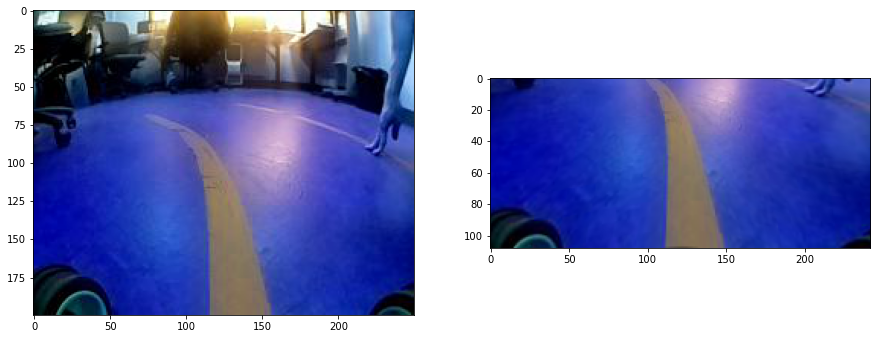

In [7]:
image = cv2.imread("../data/images/cam_images/capture_12.jpg")

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

h,  w = image.shape[:2]
newcameramtx, roi =cv2.getOptimalNewCameraMatrix(mtx, dist,(w,h),1,(w,h))

# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(image,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

h = int(2*dst.shape[0]/5)
dst = dst[h:, :]

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.show()